#### Explore and Cluster User-Level Data

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.decomposition import NMF, PCA
from sklearn.cluster import MiniBatchKMeans

In [19]:
#Function to Print Percentiles (for Cleaning)
def percentiles(df, variable):
    print "Min:  "+str(df[variable].quantile(q=0.00))
    print "1st:  "+str(df[variable].quantile(q=0.01))
    print "5th:  "+str(df[variable].quantile(q=0.05))
    print "10th: "+str(df[variable].quantile(q=0.10))
    print "25th: "+str(df[variable].quantile(q=0.25))
    print "50th: "+str(df[variable].quantile(q=0.50))
    print "75th: "+str(df[variable].quantile(q=0.75))
    print "90th: "+str(df[variable].quantile(q=0.90))
    print "95th: "+str(df[variable].quantile(q=0.95))
    print "99th: "+str(df[variable].quantile(q=0.99))
    print "Max:  "+str(df[variable].quantile(q=1.00))

In [20]:
user = pd.read_pickle("data/yelp/dataframes/yelp_review_user.pkl")
user.head(5)

,location,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total
31623,"Madison, WI",C7TFZoVARUIVar5n5VNamg,0,0,0,0,0,3
62595,"Pittsburg, PA",ySPSkuI5oEUOYCoV3tDFhw,0,0,0,0,0,1
60578,"Pittsburg, PA",sKZBaKFKQ3D85yEh_JLWAg,0,0,0,0,0,1
4193,"Charlotte, NC",8I1-3v8-nTjfmjaI2SSnug,0,0,0,0,0,3
41658,"Madison, WI",yS0qbhrEPCx0c6RwNj5_oA,0,0,0,0,0,1


In [21]:
##Look At Distribution of Total # Relevant
print "Total Sentences..."
percentiles(user, "total")

print "Relevant Sentences..."
percentiles(user, "relevant")

Total Sentences...
Min:  1.0
1st:  1.0
5th:  2.0
10th: 3.0
25th: 5.0
50th: 9.0
75th: 20.0
90th: 46.0
95th: 85.0
99th: 365.71
Max:  7186.0
Relevant Sentences...
Min:  0.0
1st:  0.0
5th:  1.0
10th: 2.0
25th: 3.0
50th: 5.0
75th: 12.0
90th: 28.0
95th: 50.0
99th: 219.0
Max:  4153.0


#### Let's Focus on users in the 75th - 99th percentile range

In [22]:
user = user[(user.relevant>=12) & (user.relevant<=219)]
user.reset_index(drop=True, inplace=True)
print user.location.value_counts()

Charlotte, NC    6878
Pittsburg, PA    5239
Madison, WI      3432
Name: location, dtype: int64


#### Calculate % Of Each Topic Discussed

In [23]:
user["pct_food"] = user["topic_food"] / user["relevant"]
user["pct_service"] = user["topic_service"] / user["relevant"]
user["pct_ambience"] = user["topic_ambience"] / user["relevant"]
user["pct_value"] = user["topic_value"] / user["relevant"]
user.head(10)

,location,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total,pct_food,pct_service,pct_ambience,pct_value
0,"Charlotte, NC",qEOUrhX7uhB-9D7uTAKyJg,10,2,1,1,12,20,0.833333,0.166667,0.083333,0.083333
1,"Charlotte, NC",VlCIxw9UOTxLTfE-dMWw0A,9,2,1,1,12,18,0.750000,0.166667,0.083333,0.083333
2,"Charlotte, NC",9jLgxE6Bltubt7Ri4jTC9A,7,3,3,0,12,16,0.583333,0.250000,0.250000,0.000000
3,"Charlotte, NC",KDioFcWlX7avlvftBPDpLQ,6,7,2,1,12,27,0.500000,0.583333,0.166667,0.083333
4,"Charlotte, NC",ctax9ECmvdyYqZJL-XG0pQ,7,3,2,0,12,16,0.583333,0.250000,0.166667,0.000000
5,"Pittsburg, PA",Gf-7bqM-dTaImuvfZGhJ2g,9,2,1,4,12,22,0.750000,0.166667,0.083333,0.333333
6,"Charlotte, NC",kuBAuB1zvQ8AzKUCGf_Q6Q,7,1,4,2,12,19,0.583333,0.083333,0.333333,0.166667
7,"Charlotte, NC",vciRqL5e1_B5-szqWSxavA,10,4,3,2,12,23,0.833333,0.333333,0.250000,0.166667
8,"Charlotte, NC",aESDnmcgHZhECmHa685fFQ,8,1,2,1,12,22,0.666667,0.083333,0.166667,0.083333
9,"Pittsburg, PA",ekHwPi7mifQ2ALpUSsYnmQ,4,6,4,2,12,21,0.333333,0.500000,0.333333,0.166667


#### Look at % Across Data

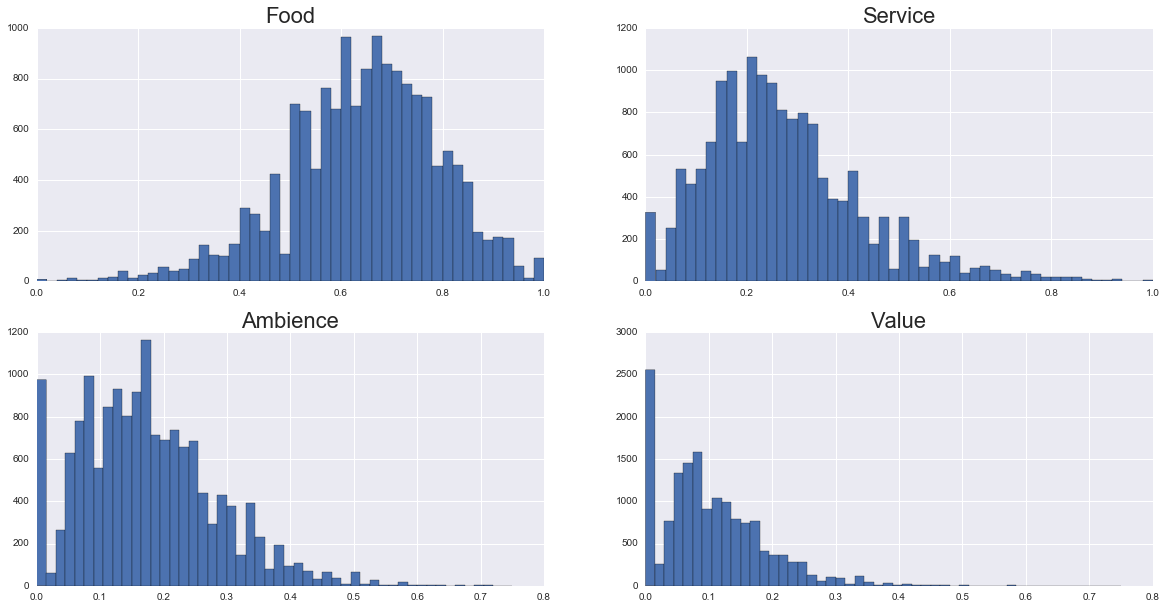

In [24]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.hist(user.pct_food, bins=50)
plt.title("Food", fontsize=22)

plt.subplot(2,2,2)
plt.hist(user.pct_service, bins=50)
plt.title("Service", fontsize=22)

plt.subplot(2,2,3)
plt.hist(user.pct_ambience, bins=50)
plt.title("Ambience", fontsize=22)

plt.subplot(2,2,4)
plt.hist(user.pct_value, bins=50)
plt.title("Value", fontsize=22)

#### Apply PCA for Dimentionality Reduction

In [25]:
reducer = PCA(n_components=2, whiten=True)
reduced = reducer.fit_transform(user[["pct_food","pct_service","pct_ambience","pct_value"]])

reduced = pd.DataFrame(reduced, columns=["PCA_1", "PCA_2"])
reduced.head(5)

,PCA_1,PCA_2
0,-1.082740,0.792646
1,-0.787806,0.547124
2,0.166272,-0.684023
3,1.620466,0.799437
4,0.131627,-0.135445


In [26]:
user = pd.concat([user, reduced], axis=1)
user.head(5)

,location,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total,pct_food,pct_service,pct_ambience,pct_value,PCA_1,PCA_2
0,"Charlotte, NC",qEOUrhX7uhB-9D7uTAKyJg,10,2,1,1,12,20,0.833333,0.166667,0.083333,0.083333,-1.082740,0.792646
1,"Charlotte, NC",VlCIxw9UOTxLTfE-dMWw0A,9,2,1,1,12,18,0.750000,0.166667,0.083333,0.083333,-0.787806,0.547124
2,"Charlotte, NC",9jLgxE6Bltubt7Ri4jTC9A,7,3,3,0,12,16,0.583333,0.250000,0.250000,0.000000,0.166272,-0.684023
3,"Charlotte, NC",KDioFcWlX7avlvftBPDpLQ,6,7,2,1,12,27,0.500000,0.583333,0.166667,0.083333,1.620466,0.799437
4,"Charlotte, NC",ctax9ECmvdyYqZJL-XG0pQ,7,3,2,0,12,16,0.583333,0.250000,0.166667,0.000000,0.131627,-0.135445


In [28]:
user.location.value_counts()

Charlotte, NC    6878
Pittsburg, PA    5239
Madison, WI      3432
Name: location, dtype: int64

In [35]:
madison = user[user.location=="Madison, WI"]
charlotte = user[user.location=="Charlotte, NC"]
pittsburgh = user[user.location=="Pittsburg, PA"]

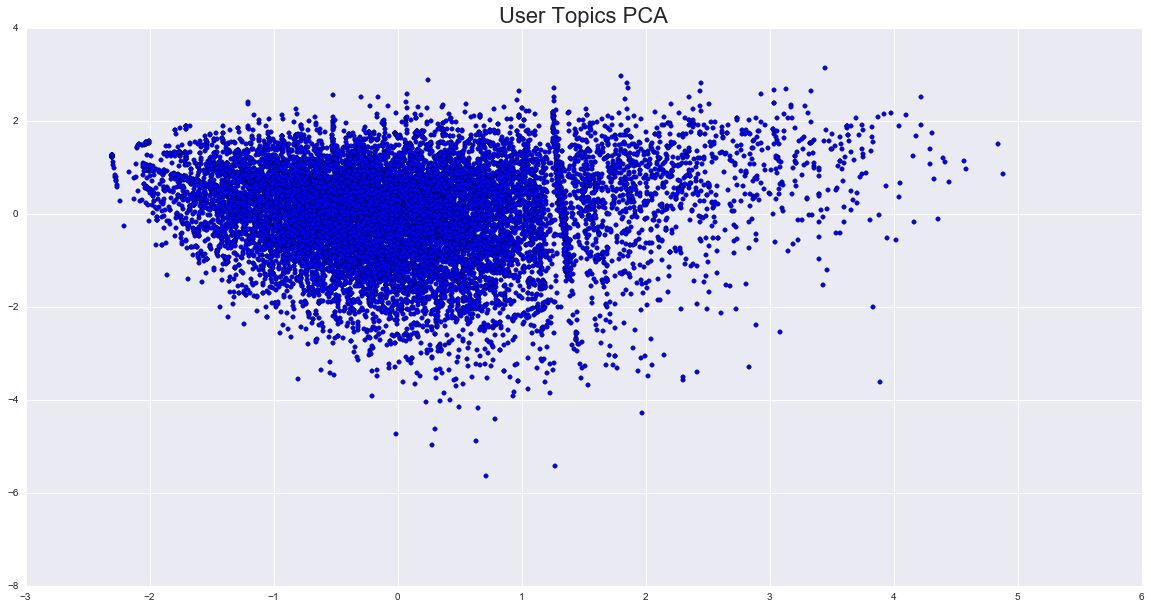

In [45]:
plt.figure(figsize=(20,10))
plt.scatter(user.PCA_1, user.PCA_2)
plt.title("User Topics PCA", fontsize=22)

In [44]:
### Do We Get The Same Results with NMF?

#### Try Mini Batch K-Means on Without PCA on Charlotte, NC

In [41]:
madison["flag"] = 0
madison.ix[madison.PCA_1>1.5, "flag"]=1
madison.flag.value_counts()

/Users/willhuguenin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/willhuguenin/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0    3226
1     206
Name: flag, dtype: int64

In [48]:
madison.groupby(by="flag")[["pct_food","pct_service","pct_ambience","pct_value","relevant"]].mean()

,pct_food,pct_service,pct_ambience,pct_value,relevant
flag,,,,,
0,0.668747,0.237997,0.178437,0.106761,35.651891
1,0.354684,0.610027,0.171355,0.100402,21.427184


In [49]:
madison.groupby(by="flag")[["pct_food","pct_service","pct_ambience","pct_value","relevant"]].std()

,pct_food,pct_service,pct_ambience,pct_value,relevant
flag,,,,,
0,0.125384,0.117730,0.106794,0.080077,34.435596
1,0.116289,0.128639,0.129122,0.091937,13.949457
